In [88]:
%matplotlib inline
import numpy as np
from sklearn import svm
from sklearn import preprocessing
import matplotlib.pyplot as plt

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [3]:
with open("/home/christopher/data/ml/digit-recognizer/train.csv", "r") as data:
    fullTrain = np.loadtxt(data, delimiter=",", skiprows=1, dtype="float64")
with open("/home/christopher/data/ml/digit-recognizer/test.csv", "r") as data:
    fullTest = np.loadtxt(data, delimiter=",", skiprows=1, dtype="float64")

In [4]:
train = fullTrain
test = fullTest

In [5]:
trainResults = train[:,0]
trainData = train[:,1:]
testData = test

# Look at the data

Let's look at the data and think about it so that we can do more intelligent things than just throw statistics at it.

In this case I am not sure that we can, but this is a good step later where there may be some theory or physics that we can apply.

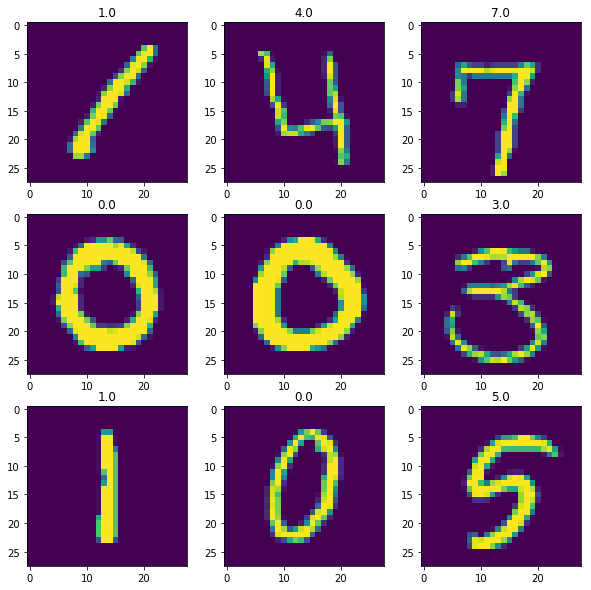

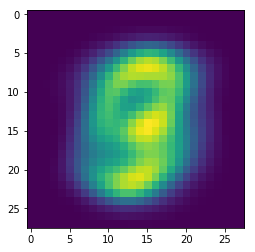

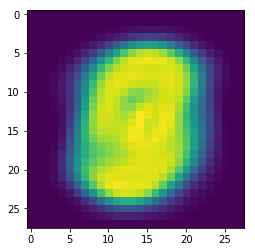

In [114]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(9):
    ax = axs[i%3][i//3]
    ax.imshow(trainData[i].reshape(28, 28))
    ax.set_title(trainResults[i])

fig, ax = plt.subplots()
ax.imshow(np.mean(trainData, axis=0).reshape(28, 28))

fig, ax = plt.subplots()
ax.imshow(np.var(trainData, axis=0).reshape(28, 28))

# Scaling

We need to scale our data to have mean 0, variance 1.

Let's do this before we do anything else so that we are always using the data we will be analysing.

In [6]:
scaler = preprocessing.StandardScaler().fit(trainData)
scaledTrainData = scaler.transform(trainData)
scaledTestData = scaler.transform(testData)

# PCA

Not all of the components of our vectors have useful data. We can run PCA to determine which + how many components we need.

First, let us just play with the data and see how many components are needed to get certain percentages of data explained.

Then we can apply a cut.

In [7]:
from sklearn.decomposition import PCA
pcaTest = PCA()
pcaTest.fit(scaledTrainData)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0.8, 1.0)

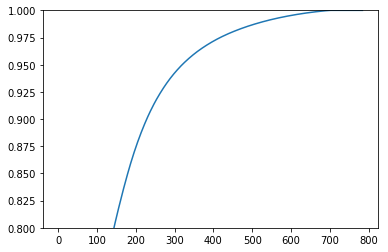

In [8]:
cumulative_explained = [0]
for i in range(len(pcaTest.explained_variance_ratio_)):
    cumulative_explained.append(sum(pcaTest.explained_variance_ratio_[:i+1]))
plt.plot(cumulative_explained)
plt.ylim([0.8, 1.0]) # we only care about the high end

For this component remember:
Large positive values mean that there is lots of variance in that feature.
Values close to 0 mean that there is little variance along in that feature.
Large negative values mean that (I think the same as large positive but I'm not sure).



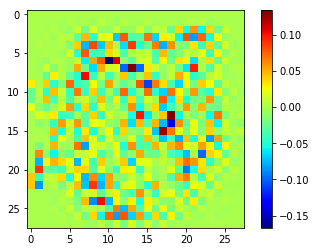

In [89]:
# Let's look at some components
plt.imshow(pcaTest.components_[600].reshape(28,28), cmap='jet')
plt.colorbar()
assert sum(pcaTest.components_[0]**2) - 1 < 0.00001
print("""For this component remember:
Large positive values mean that there is lots of variance in that feature.
Values close to 0 mean that there is little variance along in that feature.
Large negative values mean that (I think the same as large positive but I'm not sure).
""")

In [102]:
# Lets make some crazy graphs to show where our variance is
data = [
    go.Heatmap(
        visible = False,
        z = np.sum(np.power(pcaTest.components_[:i], 2), axis=0).reshape(28, 28)
    ) for i in range(1, len(pcaTest.components_), 10)
]

# Create steps for each heatmap. Each step (when selected) sets the heatmap at that index to visible.
steps = []
for i in range(len(data)):
    steps.append({"method": "restyle", "args": ["visible", [i == j for j in range(len(data))]]})

data[0]["visible"] = True # Just setting this "active" doesn't do anything. Active reflects what is active
sliders = [{"active": 0, "steps": steps}]
py.iplot({"data": data, "layout": {"sliders": sliders}}, filename='basic-heatmap')

Having played with it to get a sense of what is going on, lets actually use PCA to reduce the size of our data

In [25]:
pca = PCA(n_components=0.99) # Get 99% of the info
pca.fit(scaledTrainData)
redScaledTrainData = pca.transform(scaledTrainData)
redScaledTestData = pca.transform(scaledTestData)

In [104]:
print(redScaledTrainData.shape)

(42000, 533)


# LDA

Let's see if picking out dimensions that separate our classes helps. This might not work - we only have 10 classes (and so can only have 10 dimensions post LDA) which might not be enough.

In [107]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA() # I think that if you don't specify n_components, it will find as many as it can
lda.fit(redScaledTrainData, trainResults)
lda.score(redScaledTrainData, trainResults)

0.87328571428571433

In [108]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA() # I think that if you don't specify n_components, it will find as many as it can
qda.fit(redScaledTrainData, trainResults)
qda.score(redScaledTrainData, trainResults)

/home/christopher/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning:

Variables are collinear



0.73738095238095236

These don't seem very good... We see below that just running off the PCA'ed data we are getting 98% success. Going through LDA, while it would make things smaller and faster comes with a big accuracy tradeoff.

So, no transforms applied.

# Fit

Fit a support vector classification model to our data then predict our test data from that.

In [26]:
clf = svm.SVC()   
_ = clf.fit(redScaledTrainData, trainResults)

In [109]:
# Now lets analyse what our clf has found
print(clf.score(redScaledTrainData, trainResults))

0.98980952381


In [ ]:
res = clf.predict(redScaledTestData)

In [ ]:
with open("results.csv", "w") as f:
    f.write("ImageId,Label\n")
    for i, r in enumerate(res):
        f.write("{},{}\n".format(i+1, int(r)))